# Data Description and Processing

# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import warnings
from sklearn import random_projection
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
import nltk
from nltk import word_tokenize
from sklearn.neighbors import NearestNeighbors
!pip install surprise
from surprise import SVD, KNNBasic, BaselineOnly, NMF
from surprise import Reader
from surprise import Dataset 
from surprise.model_selection import cross_validate
import time, os
from surprise.model_selection import split
from surprise.model_selection import GridSearchCV
from scipy.spatial.distance import correlation
from sklearn.metrics import roc_auc_score
import hashlib

# Data Exploration and Processing

In [2]:

#choose the csv file to read under zip file
data = pd.read_csv('https://github.com/sargsyanmariam/Thesis_Recommender_Systems/raw/main/Dataset/winemag-data-130k-v2.csv.zip',encoding='utf-8')

In [3]:
print(data.head())
print(data.shape)

   Unnamed: 0   country                                        description  \
0           0     Italy  Aromas include tropical fruit, broom, brimston...   
1           1  Portugal  This is ripe and fruity, a wine that is smooth...   
2           2        US  Tart and snappy, the flavors of lime flesh and...   
3           3        US  Pineapple rind, lemon pith and orange blossom ...   
4           4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster_name  \
0              

In [4]:
data.isna().sum()

Unnamed: 0                   0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

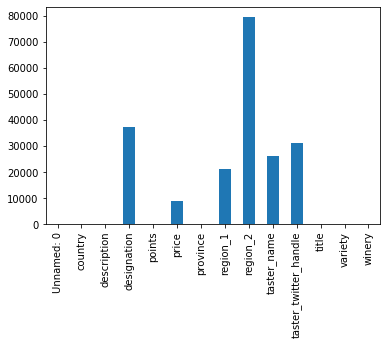

In [5]:
#checking the missing values in the dataset
data.isna().sum().plot(kind='bar')
plt.show()

        Since region_2 has the highest number of missing values, I will drop that column in order not to decrease the number of observations too much when removing the missing values.

In [6]:
data=data.drop(columns=["Unnamed: 0"],index=0)

In [7]:
data.shape

(129970, 13)

In [8]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,129907,43,US,54504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,129970,119954,This zesty red has pretty aromas that suggest ...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
designation,92505,37978,Reserve,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
points,129970,NaN,NaN,NaN,88.4471,3.03974,80,86,88,91,100
price,120975,NaN,NaN,NaN,35.3634,41.0222,4,17,25,42,3300
province,129907,425,California,36247,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_1,108723,1229,Napa Valley,4480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_2,50511,17,Central Coast,11065,NaN,NaN,NaN,NaN,NaN,NaN,NaN
taster_name,103726,19,Roger Voss,25514,NaN,NaN,NaN,NaN,NaN,NaN,NaN
taster_twitter_handle,98757,15,@vossroger,25514,NaN,NaN,NaN,NaN,NaN,NaN,NaN


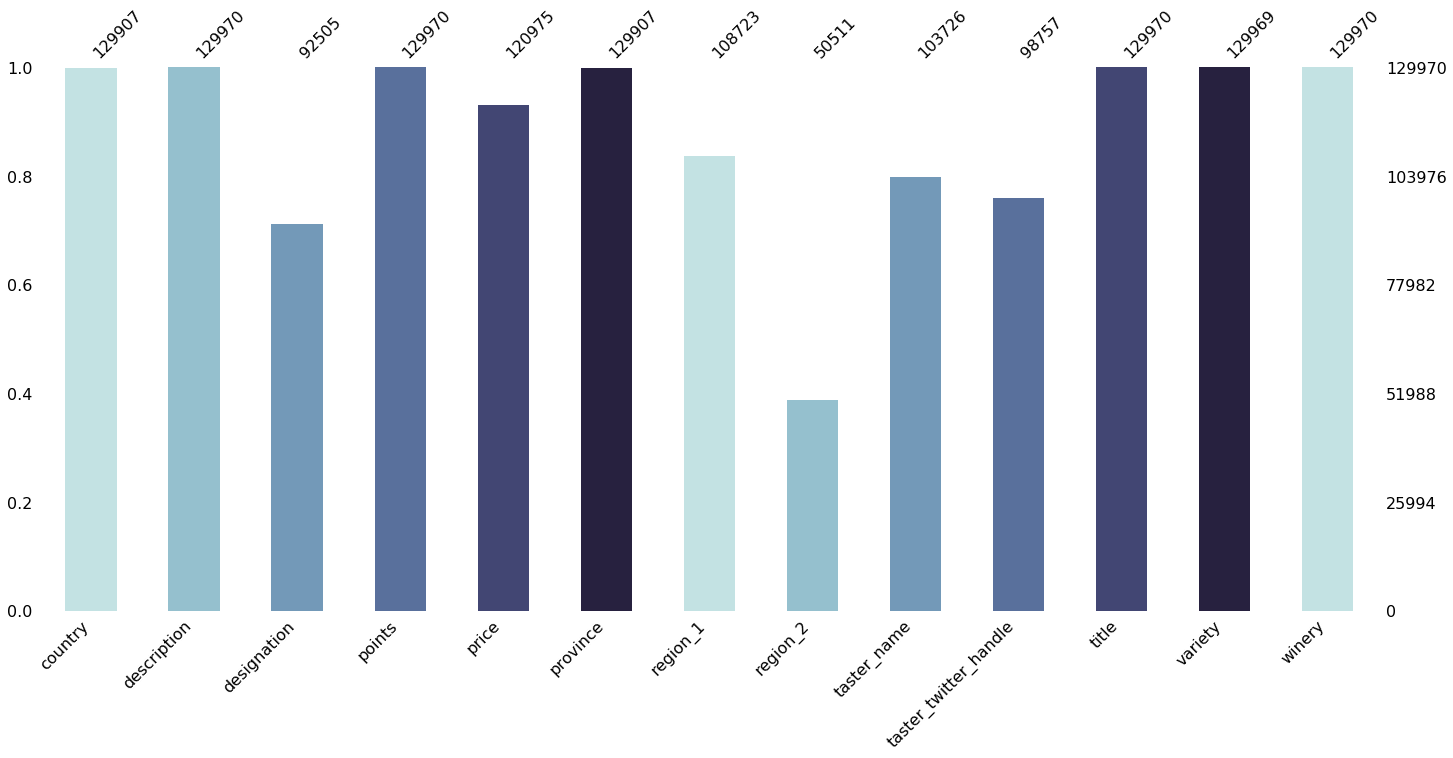

In [9]:
#visualising final missing values
msno.bar(data,color=sns.color_palette("ch:start=.2,rot=-.3"))
plt.show()

In [10]:
#"Unknown" category will be used to replace missing values in  region_1, region_2, taster_name, taster_twitter_handle
#The rest of missing values in other variables will be dropped
data.designation.fillna("Unknown", inplace=True)
data.region_1.fillna("Unknown",inplace=True)
data.region_2.fillna("Unknown",inplace=True)
data.taster_name.fillna("Unknown Name",inplace=True)
data.taster_twitter_handle.fillna("Unknown Twitter Handle",inplace=True)

In [11]:
data=data.dropna()

In [12]:
print("Final shape of data is:", data.shape)

Final shape of data is: (120915, 13)


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120915 entries, 1 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                120915 non-null  object 
 1   description            120915 non-null  object 
 2   designation            120915 non-null  object 
 3   points                 120915 non-null  int64  
 4   price                  120915 non-null  float64
 5   province               120915 non-null  object 
 6   region_1               120915 non-null  object 
 7   region_2               120915 non-null  object 
 8   taster_name            120915 non-null  object 
 9   taster_twitter_handle  120915 non-null  object 
 10  title                  120915 non-null  object 
 11  variety                120915 non-null  object 
 12  winery                 120915 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.9+ MB


In [14]:
data.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Unknown,Unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",Unknown,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Unknown,Alexander Peartree,Unknown Twitter Handle,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian


In [15]:
data.describe(include=np.object)

,country,description,designation,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
count,120915,120915,120915,120915,120915,120915,120915,120915,120915,120915,120915
unique,42,111511,35754,422,1205,18,20,16,110582,691,15843
top,US,"Stalky aromas suggest hay and green herbs, wit...",Unknown,California,Unknown,Unknown,Unknown Name,Unknown Twitter Handle,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Pinot Noir,Testarossa
freq,54265,3,34767,36104,19515,70623,24495,29415,11,12785,217


In [16]:
data.describe()

,points,price
count,120915.000000,120915.000000
mean,88.421726,35.368796
std,3.044954,41.031188
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [17]:
print('There are',data['variety'].nunique(), "variety of wines from", data['country'].nunique(), "countries")

There are 691 variety of wines from 42 countries


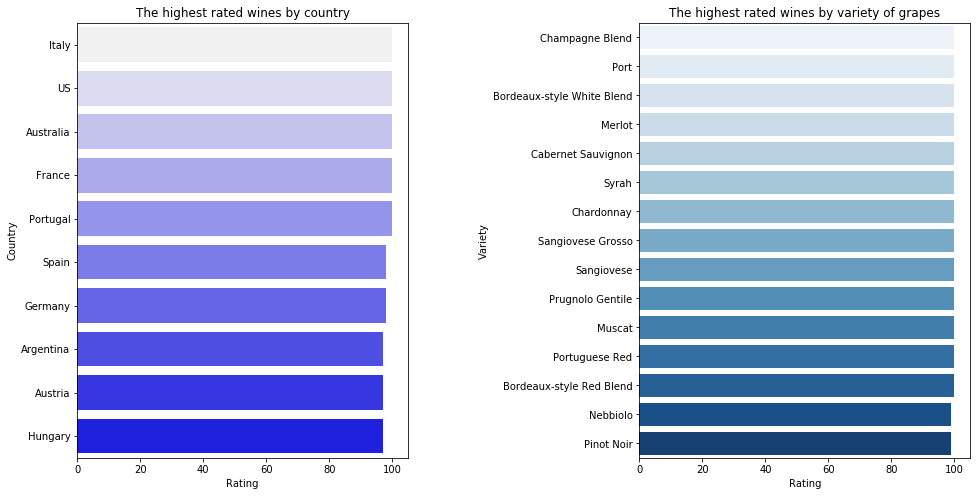

In [18]:
#highest rated wines by country and variety
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = ax.flatten()

cnt = data.groupby(['country'])['points'].max().sort_values(ascending=False).to_frame()[:10]
sns.barplot(x = cnt['points'], y = cnt.index, palette= 'light:b',ax=ax1)
ax1.set_title('The highest rated wines by country')
ax1.set_ylabel('Country')
ax1.set_xlabel('Rating')

cnt = data.groupby(['variety'])['points'].max().sort_values(ascending=False).to_frame()[:15]
sns.barplot(x = cnt['points'], y = cnt.index, palette = 'Blues',ax=ax2)
ax2.set_title('The highest rated wines by variety of grapes')
ax2.set_ylabel('Variety')
ax2.set_xlabel('Rating')

plt.subplots_adjust(wspace=0.7)

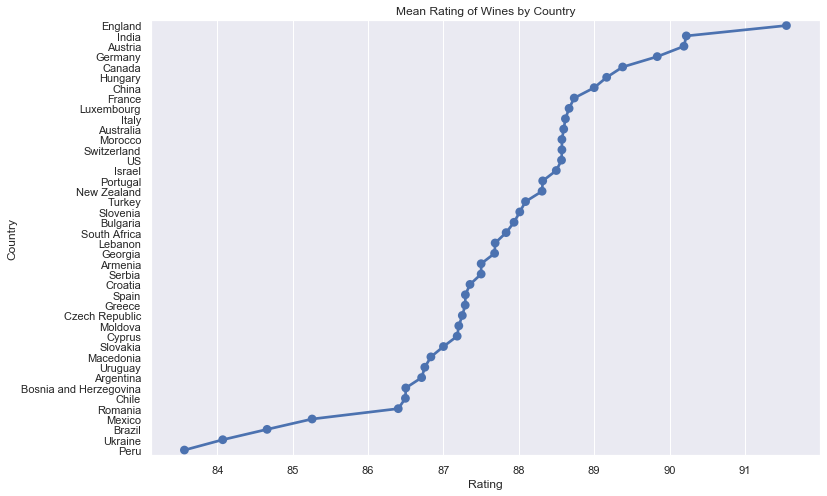

In [19]:
#by country mean ratings
sns.set_theme()

df=data.groupby(['country',]).mean()['points'].sort_values(ascending=False).to_frame()

plt.figure(figsize=(12,8))
sns.pointplot(x = df['points'] ,y = df.index ,color='b',orient='h')
plt.title('Mean Rating of Wines by Country')
plt.xlabel('Rating')
plt.ylabel("Country")

plt.show()

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


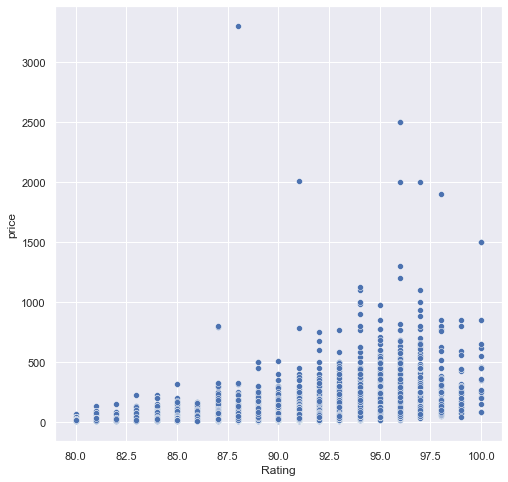

In [20]:
#the distribution of wine ratings
plt.figure(figsize=(8,8))

sns.scatterplot(data.points,data.price,color= 'b')
plt.xlabel("Rating")
plt.show()

In [21]:
pearsonr(data.points,data.price)

(0.4161971360153308, 0.0)

# Simple Recommender System

In [22]:
data["title"].value_counts()

Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)           11
Korbel NV Brut Sparkling (California)                             9
Segura Viudas NV Extra Dry Sparkling (Cava)                       8
Ruinart NV Brut Rosé  (Champagne)                                 7
Gloria Ferrer NV Blanc de Noirs Sparkling (Carneros)              7
                                                                 ..
Terlato 2008 Syrah (Dry Creek Valley)                             1
Quinta do Vale Meão 2013 Meandro do Vale Meão Red (Douro)         1
Sean Minor 2006 4B Merlot (Napa Valley)                           1
Peju 2010 Fifty/Fifty Cabernet Sauvignon-Merlot (Napa Valley)     1
Mocali 2011 Riserva  (Brunello di Montalcino)                     1
Name: title, Length: 110582, dtype: int64

In [23]:
#the data should be pivoted to be by wine title, in order to calculate number of ratings and average rating for each wine 
data_pivot =pd.pivot_table(data,index=['title','country','variety','winery']
                                ,values=['points'],aggfunc=('mean','count'))
data_pivot.head()

points  \
                                                                                             count   
title                                              country variety                 winery            
1+1=3 2008 Rosé Cabernet Sauvignon (Penedès)       Spain   Cabernet Sauvignon      1+1=3       1.0   
1+1=3 NV Brut Sparkling (Cava)                     Spain   Sparkling Blend         1+1=3       2.0   
1+1=3 NV Cygnus Brut Nature Reserva Made With O... Spain   Sparkling Blend         1+1=3       2.0   
1+1=3 NV Rosé Sparkling (Cava)                     Spain   Sparkling Blend         1+1=3       1.0   
10 Knots 2006 Beachcomber White (Paso Robles)      US      Rhône-style White Blend 10 Knots    1.0   

                                                                                                   
                                                                                             mean  
title                                              country variety                 winery          
1+1=3 2008 Rosé Cabernet Sauvignon (Penedès)       Spain   Cabernet Sauvignon      1+1=3     82.0  
1+1=3 NV Brut Sparkling (Cava)                     Spain   Sparkling Blend         1+1=3     87.0  
1+1=3 NV Cygnus Brut Nature Reserva Made With O... Spain   Sparkling Blend         1+1=3     89.0  
1+1=3 NV Rosé Sparkling (Cava)                     Spain   Sparkling Blend         1+1=3     86.0  
10 Knots 2006 Beachcomber White (Paso Robles)      US      Rhône-style White Blend 10 Knots  83.0

In [24]:
#bringing new data into normal dataframe format
data_pivot.columns=data_pivot.columns.droplevel(0)
data_pivot.columns.name=None
data_pivot = data_pivot.reset_index()

In [25]:
data_pivot.sort_values(by="count",ascending=False).head(20)

,title,country,variety,winery,count,mean
46986,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,US,Sparkling Blend,Gloria Ferrer,11.0,89.000000
57741,Korbel NV Brut Sparkling (California),US,Sparkling Blend,Korbel,9.0,86.888889
90163,Segura Viudas NV Extra Dry Sparkling (Cava),Spain,Sparkling Blend,Segura Viudas,8.0,85.625000
46982,Gloria Ferrer NV Blanc de Noirs Sparkling (Car...,US,Sparkling Blend,Gloria Ferrer,7.0,88.142857
90158,Segura Viudas NV Aria Estate Extra Dry Sparkli...,Spain,Sparkling Blend,Segura Viudas,7.0,84.142857
86918,Ruinart NV Brut Rosé (Champagne),France,Champagne Blend,Ruinart,7.0,89.714286
11094,Boizel NV Brut Réserve (Champagne),France,Champagne Blend,Boizel,6.0,88.666667
52934,J Vineyards & Winery NV Brut Rosé Sparkling (R...,US,Sparkling Blend,J Vineyards & Winery,6.0,87.666667
57751,Korbel NV Sweet Rosé Sparkling (California),US,Sparkling Blend,Korbel,6.0,86.000000
72168,Mumm Napa NV Brut Prestige Sparkling (Napa Val...,US,Sparkling Blend,Mumm Napa,6.0,88.333333


<img src="https://raw.githubusercontent.com/sargsyanmariam/Thesis_Recommender_Systems/main/Weighted%20Rating.PNG"/>

In [26]:
#defining the parameters in the formula above
v=data_pivot["count"]
R=data_pivot["mean"]
C=data_pivot["mean"].mean()
m = data_pivot['count'].quantile(0.95)
print("C =",C)
print("m =",m)

C = 88.41622914609874
m = 2.0


##### **Recommendation Engine 1**

In [27]:
#defining the function of weighted ratings according to IMDb formula above
def weighted_rating(i, m=m, C=C):
    v = i['count']
    R = i['mean']
    # Compute the weighted score
    return (v/(v+m) * R) + (m/(m+v) * C)

In [28]:
# calculating the rating of wines by using the weighted_rating function defined above
data_pivot['rating'] = data_pivot.apply(weighted_rating, axis=1)
data_pivot.head()

,title,country,variety,winery,count,mean,rating
0,1+1=3 2008 Rosé Cabernet Sauvignon (Penedès),Spain,Cabernet Sauvignon,1+1=3,1.0,82.0,86.277486
1,1+1=3 NV Brut Sparkling (Cava),Spain,Sparkling Blend,1+1=3,2.0,87.0,87.708115
2,1+1=3 NV Cygnus Brut Nature Reserva Made With ...,Spain,Sparkling Blend,1+1=3,2.0,89.0,88.708115
3,1+1=3 NV Rosé Sparkling (Cava),Spain,Sparkling Blend,1+1=3,1.0,86.0,87.610819
4,10 Knots 2006 Beachcomber White (Paso Robles),US,Rhône-style White Blend,10 Knots,1.0,83.0,86.610819


In [29]:
pd.set_option('display.max_colwidth', None)

#Sorting wines in descending order of their calculated weighted ratings
data_pivot = data_pivot.sort_values('rating', ascending=False).head(250)

#Printing the top 20 wines from 250 top wines
data_pivot[['title','country','variety','winery','rating']].head(20).reset_index()

,index,title,country,variety,winery,rating
0,19486,Chambers Rosewood Vineyards NV Rare Muscadelle (Rutherglen),Australia,Muscadelle,Chambers Rosewood Vineyards,93.458115
1,19487,Chambers Rosewood Vineyards NV Rare Muscat (Rutherglen),Australia,Muscat,Chambers Rosewood Vineyards,92.958115
2,38946,Elvio Cogno 2013 Ravera (Barolo),Italy,Nebbiolo,Elvio Cogno,92.708115
3,57899,Krug 2002 Brut (Champagne),France,Champagne Blend,Krug,92.277486
4,16495,Casa Ferreirinha 2008 Barca-Velha Red (Douro),Portugal,Portuguese Red,Casa Ferreirinha,92.277486
5,18832,Cayuse 2008 Bionic Frog Syrah (Walla Walla Valley (WA)),US,Syrah,Cayuse,92.277486
6,87683,Salon 2006 Le Mesnil Blanc de Blancs Brut Chardonnay (Champagne),France,Chardonnay,Salon,92.277486
7,22361,Château Lafite Rothschild 2010 Pauillac,France,Bordeaux-style Red Blend,Château Lafite Rothschild,92.277486
8,63809,Louis Roederer 2008 Cristal Vintage Brut (Champagne),France,Champagne Blend,Louis Roederer,92.277486
9,21425,Château Cheval Blanc 2010 Saint-Émilion,France,Bordeaux-style Red Blend,Château Cheval Blanc,92.277486


# Content-based Recommender Engine

## **Wine description-based recommender system**

In [30]:
#pivoting original data to the format that will be used in the models
data_cont=pd.pivot_table(data,index=['title','country','variety','winery','description','designation']
                                ,values=['points'],aggfunc=('mean','count'))

data_cont.columns=data_cont.columns.droplevel(0)
data_cont.columns.name=None
data_cont = data_cont.reset_index()

In [31]:
print("The final shape of data is ",data_cont.shape)

The final shape of data is  (111537, 8)


In [32]:
# creating text from all descriptions
text = " ".join(i for i in data_cont.description)

# Generating a word cloud
wordcloud = WordCloud(background_color="white",max_font_size=50, max_words=800).generate(text)


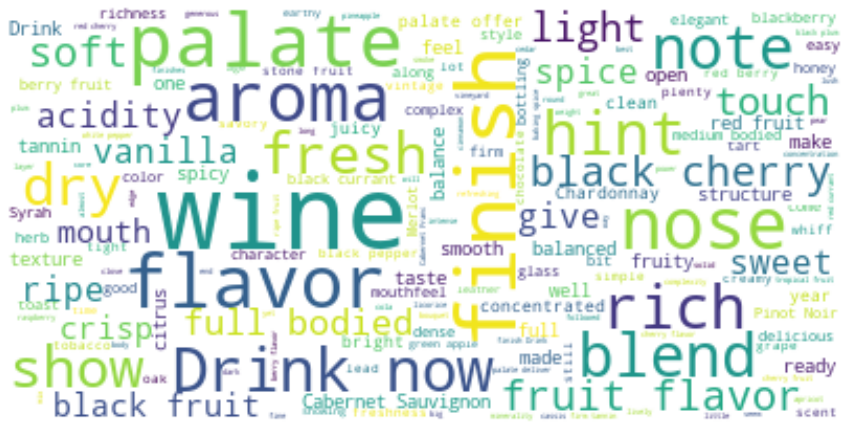

In [33]:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### TF-IDF Vectorizer

<img src="https://raw.githubusercontent.com/sargsyanmariam/Thesis_Recommender_Systems/main/Weighted%20Rating.PNG"/>

In [34]:
#removing stop words from the vector of text
tf_idf = TfidfVectorizer(stop_words='english')

#Constructing TF-IDF matrix
tfidf_matrix = tf_idf.fit_transform(data_cont['description'])

tfidf_matrix.shape

(111537, 29957)

In [35]:
type(tfidf_matrix)

scipy.sparse.csr.csr_matrix

In [36]:
#since the shape of the matrix is very big,the model will require a huge memory to run 
#therefore the data was devided into train and test parts, train size is 10%
#full implementation is not in the scope of this research
X_train, X_test = train_test_split(data_cont, train_size = 0.1,random_state=11)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

print("The size of training data is {}".format(X_train.shape))
print("The size of test data is {}".format(X_test.shape))

The size of training data is (11153, 8)
The size of test data is (100384, 8)


In [37]:
#Constructing final TF-IDF matrix
from sklearn.feature_extraction import text

#creating stop words
my_stop_words = text.ENGLISH_STOP_WORDS.union(["drink", "now", "wine", "flavor", "flavors","aromas"])

#removing stop words from the vector of text
tf_idf = TfidfVectorizer(analyzer='word', stop_words=my_stop_words, lowercase=True)

#Constructing TF-IDF matrix
tfidf_matrix_final = tf_idf.fit_transform(X_train['description'])

tfidf_matrix_final.shape

(11153, 12091)

In [38]:
cosine_simil = linear_kernel(tfidf_matrix_final, tfidf_matrix_final)

In [39]:
#Construct a reverse mapping of indices and wine titles, and if there are any duplicate titles drop them
indices_final = pd.Series(X_train.index, index=X_train['title']).drop_duplicates()

##### **Recommender Engine 2**

In [40]:
# Defining a function that takes in wine title as input and gives recommendations 
def content_recommender(title, cosine_sim=cosine_simil, df=X_train, indices=indices_final):
    # create the wine index that matches the title
    title = str(input())
    idx = indices_final[title]

    # Get the pairwsie similarity scores of all wines with that wine
    # And convert it into a list of tuples as described below
    sim_scores = list(enumerate(cosine_simil[idx]))

    # Sort  wines based on the cosine similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 6 most similar wines. Ignore the first wine.
    sim_scores = sim_scores[1:10]

    # Get the wine indices
    wine_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar wines
    return df[['title','description','variety','country','designation','mean']].iloc[wine_indices]

In [41]:
#selecting one of the wines 
X_train[X_train["title"]=='Chime 2009 Pinot Noir (Sonoma County)'][['title','description','variety','mean']]

,title,description,variety,mean
6081,Chime 2009 Pinot Noir (Sonoma County),"What a great Pinot, and look at that price. The wine is translucent in ruby hue, dry, silky in texture and crisp in acids, showing the textural hallmarks of a fine coastal bottling. The raspberry, cherry, cola and spice flavors are delicious and complex. A terrific value. Production was 1,100 cases.",Pinot Noir,91


In [42]:
#Getting recommendations for the wine selected above
content_recommender('Chime 2009 Pinot Noir (Sonoma County)')

Chime 2009 Pinot Noir (Sonoma County)


,title,description,variety,country,designation,mean
2172,Cuvaison 2008 Pinot Noir (Carneros),"This winery's basic Pinot has had a mixed record over the years. The '08 is dry and silky, but not particularly interesting at this price. It has gentle cherry, raspberry, cola, spice and oak flavors, offset by crisp acids. Drink now.",Pinot Noir,US,Unknown,86
6205,Seaside 2014 Pinot Noir (Marlborough),"This is light in hue, even for Pinot Noir, but it offers attractive, bright cherry fruit backed by crisp acids. The tannins are supple, leaving the acids to define the structure. Drink it before the end of 2017.",Pinot Noir,New Zealand,Unknown,87
2778,Black Box 2009 Merlot (California),"Blended with a little Syrah, Petite Sirah and Sangiovese, this Merlot in a big box is clearly a terrific value. It's so lush and delicious in berries and spices, it's crazy that the price works out to $6.25 for a regular bottle. With production over 200,000 cases, it's a testament to the art of blending.",Merlot,US,Unknown,90
8362,Block Nine 2010 Caiden's Vineyards Pinot Noir (California),"Not bad for the price. It's thin and silky in mouthfeel and dry, with decent raspberry, cola and mint flavors.",Pinot Noir,US,Caiden's Vineyards,85
7372,Dancing Bear Cellars 2006 Shea Cuvée Pinot Noir (Mendocino),"Translucent in color, silky in the mouth, this Mendocino-grown Pinot shows ripe, forward flavors and crisp acidity. You'll find pie-filling cherries and rhubarb, with a cola and root beer soda finish.",Pinot Noir,US,Shea Cuvée,85
3140,Windsor Oaks 2007 Clone 777 Pinot Noir (Russian River Valley),"Showing red cherry, cola and spice flavors, this is very dry and silky, like a Russian River Pinot Noir should be. It's elegant, feeling smooth and clean on the palate. Drink now.",Pinot Noir,US,Clone 777,87
2431,Rodney Strong 2009 Chardonnay (Sonoma County),"Shows all the hallmarks of a fine Chard, except complexity. It's dry, creamy and smoky in oak and lees influences, with flavors of pineapples and peaches. Easy to find, with 250,000 cases produced.",Chardonnay,US,Unknown,86
5704,Ponzi 2010 Avellana Pinot Noir (Willamette Valley),"This was not an easy vintage in which to make wine with as much fruit and concentration as this bottling, but winemaker Luisa Ponzi has done it. Deep cherry fruit comes laced with cola and chocolate notes, filling the textural, detailed and full-bodied palate. It demonstrates terrific length and an elegant, balanced finish.",Pinot Noir,US,Avellana,93
670,Sandler 2010 Bien Nacido Vineyard Pinot Noir (Santa Maria Valley),"A big, rich, fruity, oaky Pinot Noir, offering waves of raspberry and cherry pie, currant, cola, baking spice and sandalwood flavors. Tastes delicious ripe, but finishes dry in a bracing swirl of acids and tannins. Drink now–2016.",Pinot Noir,US,Bien Nacido Vineyard,90


## **Metadata-based recommender system**

In [43]:
data_cont.head(2)

,title,country,variety,winery,description,designation,count,mean
0,1+1=3 2008 Rosé Cabernet Sauvignon (Penedès),Spain,Cabernet Sauvignon,1+1=3,"The previous two years we did not find this wine to be worthy of a rating. This time, we rate it but note that it's an almost-red wine made from Cabernet Sauvignon. It's sweet smelling, with fiery plum-skin flavors that evaporate along with the mouthfeel. Leaves a burn patch on the finish. Particular to the max.",Rosé,1,82
1,1+1=3 NV Brut Sparkling (Cava),Spain,Sparkling Blend,1+1=3,"Dusty notes of citrus fruits are mild but friendly. This Cava is zesty, fresh and simple as a whole, with lime, clover and grassy flavors. Freshness is the overriding theme, while the finish tastes of apple and lime.",Brut,1,87


In [44]:
#metadats in this models are: country,designation, variety
data_cont2=data_cont[["title","country","designation","variety","description","mean"]]
data_cont2.head(4)

,title,country,designation,variety,description,mean
0,1+1=3 2008 Rosé Cabernet Sauvignon (Penedès),Spain,Rosé,Cabernet Sauvignon,"The previous two years we did not find this wine to be worthy of a rating. This time, we rate it but note that it's an almost-red wine made from Cabernet Sauvignon. It's sweet smelling, with fiery plum-skin flavors that evaporate along with the mouthfeel. Leaves a burn patch on the finish. Particular to the max.",82
1,1+1=3 NV Brut Sparkling (Cava),Spain,Brut,Sparkling Blend,"Dusty notes of citrus fruits are mild but friendly. This Cava is zesty, fresh and simple as a whole, with lime, clover and grassy flavors. Freshness is the overriding theme, while the finish tastes of apple and lime.",87
2,1+1=3 NV Brut Sparkling (Cava),Spain,Brut,Sparkling Blend,"Spiced apple and toast aromas are clean and direct. On the palate, it's malic and citric, with lime and white grapefruit flavors. A citrusy finish with a note of salt maintains freshness.",87
3,1+1=3 NV Cygnus Brut Nature Reserva Made With Organic Grapes Sparkling (Cava),Spain,Cygnus Brut Nature Reserva Made With Organic Grapes,Sparkling Blend,"Clean, fresh apple aromas and a minerally, citric palate are on point for brut nature. A lightly salty set of persimmon and apple flavors finishes lively, with dry citrus notes on the finish.",89


In [45]:
#Defining a function that removes spaces and converts to lowercase
def sanitize(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [46]:
# using the function defined above on data_cont2 dataset
for i in ["country","designation","variety"]:
    data_cont2[i] = data_cont2[i].apply(sanitize)

C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
data_cont2.head(2)

,title,country,designation,variety,description,mean
0,1+1=3 2008 Rosé Cabernet Sauvignon (Penedès),spain,rosé,cabernetsauvignon,"The previous two years we did not find this wine to be worthy of a rating. This time, we rate it but note that it's an almost-red wine made from Cabernet Sauvignon. It's sweet smelling, with fiery plum-skin flavors that evaporate along with the mouthfeel. Leaves a burn patch on the finish. Particular to the max.",82
1,1+1=3 NV Brut Sparkling (Cava),spain,brut,sparklingblend,"Dusty notes of citrus fruits are mild but friendly. This Cava is zesty, fresh and simple as a whole, with lime, clover and grassy flavors. Freshness is the overriding theme, while the finish tastes of apple and lime.",87


In [48]:
#Defining function that creates a soup out of the desired metadata ("country","designation","variety")
def create_soup(x):
    return x['country']+ ' '+ x['designation'] +" " + x['variety'] 

# Add the new soup feature
data_cont2['soup'] = data_cont2.apply(create_soup, axis=1)
data_cont2.head(2)

C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,title,country,designation,variety,description,mean,soup
0,1+1=3 2008 Rosé Cabernet Sauvignon (Penedès),spain,rosé,cabernetsauvignon,"The previous two years we did not find this wine to be worthy of a rating. This time, we rate it but note that it's an almost-red wine made from Cabernet Sauvignon. It's sweet smelling, with fiery plum-skin flavors that evaporate along with the mouthfeel. Leaves a burn patch on the finish. Particular to the max.",82,spain rosé cabernetsauvignon
1,1+1=3 NV Brut Sparkling (Cava),spain,brut,sparklingblend,"Dusty notes of citrus fruits are mild but friendly. This Cava is zesty, fresh and simple as a whole, with lime, clover and grassy flavors. Freshness is the overriding theme, while the finish tastes of apple and lime.",87,spain brut sparklingblend


In [49]:
#since the shape of the matrix is very big,the model will require a huge memory to run 
#therefore the data was devided into train and test parts, train size is 10%
#full implementation is not in the scope of this research
X_train_meta, X_test_meta = train_test_split(data_cont2, train_size = 0.1,random_state=11)

print("The size of training data is {}".format(X_train_meta.shape))
print("The size of test data is {}".format(X_test_meta.shape))

The size of training data is (11153, 7)
The size of test data is (100384, 7)


In [50]:
#Define a new CountVectorizer object and create vectors for the soup
count = CountVectorizer(stop_words='english')
count_matrix_meta = count.fit_transform(X_train_meta['soup'])
print("The size of matrix is", count_matrix_meta.shape)

The size of matrix is (11153, 6377)


In [51]:
#Compute the cosine similarity score (equivalent to linear_kernel: dot product for tf-idf vectors)
cosine_simil2 = cosine_similarity(count_matrix_meta, count_matrix_meta)

In [52]:
# Reset index of the data and construct reverse mapping again
X_train_meta = X_train_meta.reset_index()
indices2 = pd.Series(X_train_meta.index, index=X_train_meta['title'])

##### **Recommendation Engine 3**

In [53]:
#we will use the function defined above for the first model to get recommendation for the inserted wine
content_recommender('Chime 2009 Pinot Noir (Sonoma County)', cosine_simil2, X_train_meta, indices2)

Chime 2009 Pinot Noir (Sonoma County)


,title,description,variety,country,designation,mean
2172,Cuvaison 2008 Pinot Noir (Carneros),"This winery's basic Pinot has had a mixed record over the years. The '08 is dry and silky, but not particularly interesting at this price. It has gentle cherry, raspberry, cola, spice and oak flavors, offset by crisp acids. Drink now.",pinotnoir,us,unknown,86
6205,Seaside 2014 Pinot Noir (Marlborough),"This is light in hue, even for Pinot Noir, but it offers attractive, bright cherry fruit backed by crisp acids. The tannins are supple, leaving the acids to define the structure. Drink it before the end of 2017.",pinotnoir,newzealand,unknown,87
2778,Black Box 2009 Merlot (California),"Blended with a little Syrah, Petite Sirah and Sangiovese, this Merlot in a big box is clearly a terrific value. It's so lush and delicious in berries and spices, it's crazy that the price works out to $6.25 for a regular bottle. With production over 200,000 cases, it's a testament to the art of blending.",merlot,us,unknown,90
8362,Block Nine 2010 Caiden's Vineyards Pinot Noir (California),"Not bad for the price. It's thin and silky in mouthfeel and dry, with decent raspberry, cola and mint flavors.",pinotnoir,us,caiden'svineyards,85
7372,Dancing Bear Cellars 2006 Shea Cuvée Pinot Noir (Mendocino),"Translucent in color, silky in the mouth, this Mendocino-grown Pinot shows ripe, forward flavors and crisp acidity. You'll find pie-filling cherries and rhubarb, with a cola and root beer soda finish.",pinotnoir,us,sheacuvée,85
3140,Windsor Oaks 2007 Clone 777 Pinot Noir (Russian River Valley),"Showing red cherry, cola and spice flavors, this is very dry and silky, like a Russian River Pinot Noir should be. It's elegant, feeling smooth and clean on the palate. Drink now.",pinotnoir,us,clone777,87
2431,Rodney Strong 2009 Chardonnay (Sonoma County),"Shows all the hallmarks of a fine Chard, except complexity. It's dry, creamy and smoky in oak and lees influences, with flavors of pineapples and peaches. Easy to find, with 250,000 cases produced.",chardonnay,us,unknown,86
5704,Ponzi 2010 Avellana Pinot Noir (Willamette Valley),"This was not an easy vintage in which to make wine with as much fruit and concentration as this bottling, but winemaker Luisa Ponzi has done it. Deep cherry fruit comes laced with cola and chocolate notes, filling the textural, detailed and full-bodied palate. It demonstrates terrific length and an elegant, balanced finish.",pinotnoir,us,avellana,93
670,Sandler 2010 Bien Nacido Vineyard Pinot Noir (Santa Maria Valley),"A big, rich, fruity, oaky Pinot Noir, offering waves of raspberry and cherry pie, currant, cola, baking spice and sandalwood flavors. Tastes delicious ripe, but finishes dry in a bracing swirl of acids and tannins. Drink now–2016.",pinotnoir,us,biennacidovineyard,90


In [54]:
X_train_meta[X_train_meta["title"]=='Chime 2009 Pinot Noir (Sonoma County)'][['title','description','country','variety','designation','mean']]

,title,description,country,variety,designation,mean
6081,Chime 2009 Pinot Noir (Sonoma County),"What a great Pinot, and look at that price. The wine is translucent in ruby hue, dry, silky in texture and crisp in acids, showing the textural hallmarks of a fine coastal bottling. The raspberry, cherry, cola and spice flavors are delicious and complex. A terrific value. Production was 1,100 cases.",us,pinotnoir,unknown,91


# Collaborative Filtering



## Memory Based Models

### **Item-based Recommendation: NearestNeighbores from sklearn**

In [55]:
data.head(2)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",Avidagos,87,15.0,Douro,Unknown,Unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",Unknown,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [56]:
#number of wines rated by different someliers
data.taster_name.value_counts()

Unknown Name          24495
Roger Voss            20172
Michael Schachner     14944
Kerin O’Keefe          9874
Virginie Boone         9507
Paul Gregutt           9497
Matt Kettmann          6237
Joe Czerwinski         5010
Sean P. Sullivan       4925
Anna Lee C. Iijima     4369
Jim Gordon             4171
Anne Krebiehl MW       3389
Lauren Buzzeo          1712
Susan Kostrzewa        1068
Mike DeSimone           492
Jeff Jenssen            469
Alexander Peartree      413
Carrie Dykes            138
Fiona Adams              27
Christina Pickard         6
Name: taster_name, dtype: int64

In [57]:
#number of grape varieties in the database
print(data.variety.nunique())
print(np.sum(data.groupby('variety')['title'].nunique().sort_values(ascending=False)==1))

691
146


There are 146 grape varieties that were used only in one wine. While for example Pinot Noir was used in more than 11 thousand wines, while Parraleta was used in only one wine. Thsoe 146 varieties will be removed in order to decrease sparsity of the variety-wine matrix that will be constructed. 

In [58]:
#let's remove 146 wines varieties which were used to make only one type of wine
uniq=data.groupby('variety')['title'].nunique().reset_index()
np.sum(uniq[uniq.title!=1]['title'])
data_filtered = data[~data['variety'].isin(uniq[uniq.title==1]['variety'])]

In [59]:
#after filtering number of varieties in the db
print(data_filtered.variety.nunique())
print(data_filtered.variety.nunique())
print(data_filtered.title.nunique())
print(data_filtered.shape)

545
545
110436
(120756, 13)


In [60]:
#creating wine-variety dataframe
data_filtered=data_filtered[['title','variety','points']]
item_matrix=pd.pivot_table(data_filtered,index='title',columns='variety',values=['points']).fillna(0)
item_matrix.head(2)
#creating csr matrix
item_train_matrix = csr_matrix(item_matrix.values)
print(item_train_matrix.shape)

(110436, 545)


In [61]:
#The percentage on non-zero elements to the number of of elements in total (1-the ratio of non-zero elements to the number of elemnts).
#If most of the elements are nonzero, then the matrix is considered dense
sparsity=(1-np.count_nonzero(item_matrix.to_numpy())/item_matrix.to_numpy().size)*100
print("Sparsity % =",np.round(sparsity,2))

Sparsity % = 99.82


Number of elements which are 0 is 99.8% of data which shows that we have a high sparsity issue.

*In order to decide the number of k for NearestNeighbors model constucted on our train data, from sklearn KMeans will be used.*

In [62]:
#item_matrix to dataframe simple format to easily find indexes by wine names
item_matrix2=item_matrix.copy()
item_matrix2.columns=item_matrix2.columns.droplevel(0)
item_matrix2.columns.name=None
item_matrix2 = item_matrix2.reset_index()
item_matrix2[item_matrix2['title']=='Chime 2009 Pinot Noir (Sonoma County)'].index[0]

20625

In [63]:
#KNN
knn = NearestNeighbors(n_neighbors=10
                       ,algorithm= 'brute', metric= 'cosine')
model_knn = knn.fit(item_train_matrix)

##### **Recommendation Engine 4**

In [64]:
#for randomly choosing any wine index: query_index = np.random.choice(item_matrix.shape[0])
#query_index=item_matrix2[item_matrix2['title']=='Chime 2009 Pinot Noir (Sonoma County)'].index[0]
#title=str(input())
title='Chime 2009 Pinot Noir (Sonoma County)'
query_index=item_matrix2[item_matrix2['title']==str(title)].index[0]
distance, indice = model_knn.kneighbors(item_matrix.iloc[query_index,:].values.reshape(1,-1),n_neighbors=6)
for i in range(0, len(distance.flatten())):
    if  i == 0:
        print('Recmmendation for {0}:\n'.format(item_matrix.index[query_index]))
    else:
        results='{0}: {1} with distance: {2}'.format(i,item_matrix.index[indice.flatten()[i]],distance.flatten()[i])
        print(results)

Recmmendation for Chime 2009 Pinot Noir (Sonoma County):

1: Luminous Hills 2010 Lux Pinot Noir with distance: 0.0
2: Big Basin 2014 Lester Family Vineyard Pinot Noir (Santa Cruz Mountains) with distance: 0.0
3: Lumos 2009 5 Block Pinot Noir (Willamette Valley) with distance: 0.0
4: Lumos 2008 North Temperance Pinot Noir (Willamette Valley) with distance: 0.0
5: Big Basin 2014 Woodruff Family Vineyard Pinot Noir (Santa Cruz Mountains) with distance: 0.0


In [65]:
data[data['title']=='Chime 2009 Pinot Noir (Sonoma County)'][['title','price','description','points','country']]


,title,price,description,points,country
10306,Chime 2009 Pinot Noir (Sonoma County),19.0,"What a great Pinot, and look at that price. The wine is translucent in ruby hue, dry, silky in texture and crisp in acids, showing the textural hallmarks of a fine coastal bottling. The raspberry, cherry, cola and spice flavors are delicious and complex. A terrific value. Production was 1,100 cases.",91,US


In [66]:
data[data['title']=='Big Basin 2014 Woodruff Family Vineyard Pinot Noir (Santa Cruz Mountains)'][['title','price','description','points','country']]

,title,price,description,points,country
125181,Big Basin 2014 Woodruff Family Vineyard Pinot Noir (Santa Cruz Mountains),59.0,"Made from unknown heritage clones, this bottling lays down a cran-raspberry base and then lavishes on the herbal components of thyme, bay leaf, sagebrush and pine resin. That underbrush character is strong on the sip too, from oregano to incense, ensuring that this wine will bring plenty of nuance to any dish served, from light fish to steak.",93,US


### **Model-based Recommendations: Surprise**

In [67]:
from surprise import SVD, KNNBasic, BaselineOnly, NMF
from surprise import Reader
from surprise import Dataset 
from surprise.model_selection import cross_validate
import time, os
from surprise.model_selection import split
from surprise.model_selection import GridSearchCV

In [68]:
reader = Reader()
data_mod = Dataset.load_from_df(data_filtered[['variety', 'title', 'points']], reader)

In [69]:
param_grid = {'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
grid_search = GridSearchCV(SVD, param_grid, measures=['RMSE'])
grid_search.fit(data_mod)
grid_search.best_score['rmse']

83.47816935355124

In [70]:
param_grid = {'n_factors': [15]}
grid_search = GridSearchCV(NMF, param_grid, measures=['RMSE'])
grid_search.fit(data_mod)
grid_search.best_score['rmse']

83.47821659834565

In [71]:
#SVD
results=cross_validate(SVD(), data_mod,  cv=5, verbose=True,return_train_measures=True, n_jobs=1)
pd.DataFrame(results)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    83.4921 83.4722 83.4770 83.4751 83.4744 83.4782 0.0071  
MAE (testset)     83.4368 83.4164 83.4213 83.4194 83.4192 83.4226 0.0072  
RMSE (trainset)   83.4747 83.4797 83.4785 83.4789 83.4791 83.4782 0.0018  
MAE (trainset)    83.4191 83.4242 83.4229 83.4234 83.4235 83.4226 0.0018  
Fit time          5.91    5.87    5.41    5.60    5.51    5.66    0.20    
Test time         0.21    0.13    0.11    0.20    0.11    0.15    0.04    


,test_rmse,train_rmse,test_mae,train_mae,fit_time,test_time
0,83.492059,83.474698,83.436775,83.419072,5.910203,0.210438
1,83.472178,83.479668,83.416422,83.424160,5.873268,0.128656
2,83.477040,83.478453,83.421266,83.422949,5.410538,0.106715
3,83.475127,83.478931,83.419403,83.423415,5.603027,0.199467
4,83.474445,83.479102,83.419196,83.423467,5.507309,0.109706


In [72]:
#NMF
results2=cross_validate(NMF(), data_mod, cv=5, verbose=True,return_train_measures=True, n_jobs=1)
pd.DataFrame(results2)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    83.4915 83.4602 83.4686 83.4859 83.4847 83.4782 0.0118  
MAE (testset)     83.4362 83.4048 83.4130 83.4300 83.4291 83.4226 0.0118  
RMSE (trainset)   83.4748 83.4827 83.4806 83.4762 83.4765 83.4782 0.0029  
MAE (trainset)    83.4192 83.4271 83.4250 83.4208 83.4210 83.4226 0.0029  
Fit time          11.98   12.16   12.01   13.33   13.07   12.51   0.57    
Test time         0.11    0.11    0.11    0.18    0.13    0.13    0.03    


,test_rmse,train_rmse,test_mae,train_mae,fit_time,test_time
0,83.491515,83.474843,83.436235,83.419217,11.977020,0.111701
1,83.460185,83.482666,83.404787,83.427069,12.157515,0.112691
2,83.468620,83.480557,83.412985,83.425019,12.008932,0.108710
3,83.485880,83.476245,83.430011,83.420765,13.331374,0.181511
4,83.484698,83.476540,83.429098,83.420993,13.066081,0.134607


In [73]:
#BaselineOnly
results3=cross_validate(BaselineOnly(), data_mod, measures=['RMSE','MAE'], cv=5, verbose=True,return_train_measures=True, n_jobs=1)
pd.DataFrame(results3)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    83.4965 83.4725 83.4739 83.4548 83.4931 83.4782 0.0152  
MAE (testset)     83.4405 83.4165 83.4188 83.3995 83.4377 83.4226 0.0150  
RMSE (trainset)   83.4736 83.4796 83.4792 83.4840 83.4744 83.4782 0.0038  
MAE (trainset)    83.4181 83.4241 83.4236 83.4284 83.4188 83.4226 0.0038  
Fit time          0.44    0.41    0.46    0.53    0.41    0.45    0.04    
Test time         0.12    0.11    0.11    0.18    0.11    0.12    0.03    


,test_rmse,train_rmse,test_mae,train_mae,fit_time,test_time
0,83.496537,83.473578,83.440543,83.418130,0.435726,0.117685
1,83.472502,83.479587,83.416546,83.424129,0.414205,0.109674
2,83.473948,83.479226,83.418782,83.423570,0.461159,0.113695
3,83.454790,83.484014,83.399528,83.428384,0.528378,0.175557
4,83.493067,83.474446,83.437663,83.418850,0.407949,0.106703


In [74]:
#KNNBasic
results4=cross_validate(KNNBasic(), data_mod, measures=['RMSE','MAE'], cv=5, verbose=True,return_train_measures=True, n_jobs=1)
pd.DataFrame(results4)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    83.4796 83.4976 83.4518 83.4847 83.4772 83.4782 0.0150  
MAE (testset)     83.4238 83.4415 83.3959 83.4298 83.4221 83.4226 0.0150  
RMSE (trainset)   83.4778 83.4733 83.4848 83.4765 83.4784 83.4782 0.0037  
MAE (trainset)    83.4223 83.4179 83.4293 83.4208 83.4228 83.4226 0.0037  
Fit time          0.04    0.05    0.05    0.05    0.05    0.05    0.00    
Test time         0.22    0.15    0.17    0.20    0.19    0.19    0.02    


,test_rmse,train_rmse,test_mae,train_mae,fit_time,test_time
0,83.479629,83.477806,83.423816,83.422312,0.044914,0.217387
1,83.497590,83.473315,83.441514,83.417887,0.053823,0.146606
2,83.451771,83.484769,83.395884,83.429295,0.049833,0.171543
3,83.484686,83.476541,83.429796,83.420817,0.046875,0.201489
4,83.477169,83.478420,83.422053,83.422752,0.052858,0.194482


In [75]:
#Mean for benchmarks of all models
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(),BaselineOnly(),KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_mod, measures=['RMSE','MAE'], cv=5, verbose=False,return_train_measures=True, n_jobs=1)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
benchmark=pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
benchmark

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,train_rmse,test_mae,train_mae,fit_time,test_time
Algorithm,,,,,,
BaselineOnly,83.478165,83.478170,83.422613,83.422613,0.429744,0.106315
KNNBasic,83.478165,83.478170,83.422613,83.422613,0.042502,0.184001
SVD,83.478170,83.478170,83.422612,83.422613,5.829232,0.141422
NMF,83.478207,83.478171,83.422652,83.422613,13.098342,0.117488


# **Hybrid Model**

### Content Based Data Processing

In [76]:
#metadats in this models are: country,designation, variety
data_cont3=data_cont[["title","country","designation","variety","description","mean"]]
X_train3, X_test3 = train_test_split(data_cont3, train_size = 0.1,random_state=11)

In [77]:
#Defining a function that removes spaces and converts to lowercase
def sanitize(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [78]:
for i in ["country","designation"]:
    X_train3[i] = X_train3[i].apply(sanitize)

C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [79]:
#Defining function that creates a soup out of the desired metadata ("country","designation","variety")
def create_soup(x):
    return x['country']+ ' '+ x['designation'] + " "+ x['description']

# Add the new soup feature
X_train3['soup'] = X_train3.apply(create_soup, axis=1)
X_train3.head(2)

C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,title,country,designation,variety,description,mean,soup
64820,Lujon 2008 Cabernet Sauvignon (Walla Walla Valley (WA)),us,unknown,Cabernet Sauvignon,"Broadly fruity, with a palate of mixed red berries and cherries. Light and balanced, this is well-made, of medium length, and ready to drink right away.",87,"us unknown Broadly fruity, with a palate of mixed red berries and cherries. Light and balanced, this is well-made, of medium length, and ready to drink right away."
100812,Torii Mor 2009 Dundee Hills Select Pinot Noir (Dundee Hills),us,dundeehillsselect,Pinot Noir,"The 2009 Torii Mors are not widely separated in style or substance. The Select is smooth and fruity, with citrusy acids and light red-berry flavors. It's ready to drink, but does not show the depth or detail for long-term aging.",87,"us dundeehillsselect The 2009 Torii Mors are not widely separated in style or substance. The Select is smooth and fruity, with citrusy acids and light red-berry flavors. It's ready to drink, but does not show the depth or detail for long-term aging."


In [80]:
#Constructing final TF-IDF matrix
from sklearn.feature_extraction import text

#creating stop words
my_stop_words3 = text.ENGLISH_STOP_WORDS.union(["drink", "now", "wine", "flavor", 
                                                "flavors","aromas",'taste','nose',
                                                'note','show','delicious','fruit'])

#removing stop words from the vector of text
tf_idf = TfidfVectorizer(analyzer='word', stop_words=my_stop_words3, lowercase=True)

#Constructing TF-IDF matrix
tfidf_matrix_final3 = tf_idf.fit_transform(X_train3['soup'])

tfidf_matrix_final3.shape


(11153, 17736)

In [81]:
cosine_simil3 = linear_kernel(tfidf_matrix_final3, tfidf_matrix_final3)

In [82]:
# running randomized search on SVD in order to find best parameters
from surprise.model_selection import RandomizedSearchCV
params = {'n_factors': [1,5,10,25,50,75,100], 'reg_all': [.005,.01,.02,.05,.1,.25,.5], 'lr_all':[.005,.01,.02,.05,.1,.25,.5],
         'n_epochs': [10,20,50]}
model = RandomizedSearchCV(SVD,param_distributions=params,n_jobs=-1,joblib_verbose=10, cv=5)
model.fit(data_mod)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  2.5min remaining:   33.3s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  2.7min remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.8min finished


In [83]:
# best params and score
print(model.best_score)
print(model.best_params)

{'rmse': 83.47816778425602, 'mae': 83.42261263903413}
{'rmse': {'n_factors': 25, 'reg_all': 0.05, 'lr_all': 0.5, 'n_epochs': 50}, 'mae': {'n_factors': 25, 'reg_all': 0.05, 'lr_all': 0.5, 'n_epochs': 50}}


In [84]:
#generating IDs
X_train3['variety_id'] = X_train3[['variety']].sum(axis=1).map(hash)
X_train3.head()
X_train3.variety_id.value_counts()
X_train3.variety.value_counts()

C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Pinot Noir                  1148
Chardonnay                  1047
Cabernet Sauvignon           914
Red Blend                    764
Bordeaux-style Red Blend     529
                            ... 
Syrah-Mourvèdre                1
Saperavi-Merlot                1
Colombard-Ugni Blanc           1
Garnacha-Tempranillo           1
Greco Bianco                   1
Name: variety, Length: 351, dtype: int64

In [85]:
X_train3['wine_id'] = X_train3[['title']].sum(axis=1).map(hash)
X_train3.wine_id.value_counts()
X_train3.title.value_counts()

C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Château Pape Clément 2013  Pessac-Léognan                                                               2
Robert Hall 2015 Chardonnay (Paso Robles)                                                               2
Allure NV Bubbly Moscato (California)                                                                   2
Château de Bligny NV Grande Réserve Brut  (Champagne)                                                   2
Rotari NV Brut Talento Chardonnay (Trento)                                                              2
                                                                                                       ..
Domaine Jean Petitot et Fils 2011 Les Vignottes  (Côte de Nuits-Villages)                               1
Bacalhôa Wines of Portugal 2016 JP Azeitão Moscatel Graudo-Fernão Pires White (Península de Setúbal)    1
Karl Kaspar 2010 Kabinett Riesling (Mosel)                                                              1
Château Souverain 1996 Winemaker's Reserve Cab

In [86]:
X_train3 = X_train3.reset_index()
indices3 = pd.Series(X_train3.index, index=X_train3['title'])
indices3.head(5)

title
Lujon 2008 Cabernet Sauvignon (Walla Walla Valley (WA))         0
Torii Mor 2009 Dundee Hills Select Pinot Noir (Dundee Hills)    1
Casa Santos Lima 2013 Stones & Bones Red (Lisboa)               2
Château de Callac 2011  Graves                                  3
Foxen 2014 Pinot Noir (Sta. Rita Hills)                         4
dtype: int64

In [87]:
#Running final SVD
reader = Reader(rating_scale=(80, 100))
data = Dataset.load_from_df(X_train3[['variety_id', 'wine_id', 'mean']], reader)
trainset = data.build_full_trainset()
svd = SVD(n_factors=100,reg_all=0.02,lr_all=0.005,n_epochs=50)
svd.fit(trainset)

In [88]:
def hybrid(variety_id, title):
    idx = indices3[title]
    wine_id = X_train3.loc[X_train3.title==title]['wine_id']
    sim_scores = list(enumerate(cosine_simil3[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[0:50]
    wine_indices = [i[0] for i in sim_scores]
    wine = X_train3.iloc[wine_indices][['title', 'country','designation', 'variety','description','mean']]
    wine['Estimated_Rating'] = wine.index.map(lambda x: svd.predict(variety_id, X_train3.loc[x]['wine_id']).est)
    wine = wine.sort_values('Estimated_Rating', ascending=False)
    return wine.head(5)

In [89]:
X_train3[X_train3['title']=='Merriam 2005 Block 21 Cabernet Sauvignon (Dry Creek Valley)']

,index,title,country,designation,variety,description,mean,soup,variety_id,wine_id
13,69717,Merriam 2005 Block 21 Cabernet Sauvignon (Dry Creek Valley),us,block21,Cabernet Sauvignon,"A strongly flavored, tannic wine, marked by black currant, blackberry and blueberry flavors, sprinkled with exotic Indian spices. Drink this bone-dry Cabernet over the next several years.",87,"us block21 A strongly flavored, tannic wine, marked by black currant, blackberry and blueberry flavors, sprinkled with exotic Indian spices. Drink this bone-dry Cabernet over the next several years.",-6274285234435953183,-6468802292205962723


In [90]:
hybrid(-5659049118872099016,'Merriam 2005 Block 21 Cabernet Sauvignon (Dry Creek Valley)')

,title,country,designation,variety,description,mean,Estimated_Rating
5830,Donelan 2008 Cuvée Keltie Syrah (Sonoma County),us,cuvéekeltie,Syrah,"A beautiful young wine, notable for two things, its balance and generosity. Feels wonderfully structured, with superb tannins and a fine dose of acidity framing massive blackberry, currant, bacon, black pepper, mineral and sandalwood flavors. Bone dry, it's a superior Syrah that should develop over the next 4–6 years.",94,88.715623
661,Everett Ridge 2006 Old Vine Zinfandel (Dry Creek Valley),us,oldvine,Zinfandel,"Classic Dry Creek Zin. There's a reason this warmish Sonoma region is so famous for Zinfandel, and here it is. The wine is strong and spicy and tannic, with profuse wild berry, pine cone, red currant, cherry liqueur and cola flavors, made piquant with Indian spices. Despite its exuberance, it's dry and balanced. Just lovely if you're in the mood for Zinfandel.",92,88.700647
989,Tanner 2013 Estate Grown Petite Sirah (Sierra Foothills),us,estategrown,Petite Sirah,"Richness and density highlight this full-bodied and deftly oaked wine that smells like baking spices and black pepper sprinkled on ripe black cherry and dark chocolate. The texture is very inviting, almost thick, and beautifully marries the ripe fruit with velvety tannins.",91,88.659023
3469,Loring Wine Company 2015 Rosella's Vineyard Pinot Noir (Santa Lucia Highlands),us,rosella'svineyard,Pinot Noir,"Intense baked plum and black cherry aromas meet with vanilla, caramel and sagebrush on the nose of this bottling from one of the appellation's most coveted vineyards. The tangy, energetic and grippy palate offers crushed cranberry flavors, more black plum, gingerbread and exotic Indian spice on the finish.",94,88.639885
6301,Straight Line 2013 Tempranillo (California),us,unknown,Tempranillo,"This wine has rich blueberry aromas, a softly tannic texture and and black currant flavors that open more with each sip. Concentrated and full in body, it's a luxurious-feeling and abundantly flavored wine that lingers long on the palate.",91,88.623443
